# Exploração dados COVID-19 em Portugal

In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")
df.head()

,id,url,data_relatorio,suspeitos,confirmados,nao_confirmados,aguarda_resultados,recuperados,obitos,em_vigilancia,...,obitos_masculino_80_sup,obitos_feminino_0_9,obitos_feminino_10_19,obitos_feminino_20_29,obitos_feminino_30_39,obitos_feminino_40_49,obitos_feminino_50_59,obitos_feminino_60_69,obitos_feminino_70_79,obitos_feminino_80_sup
0,5,https://covid19.min-saude.pt/wp-content/upload...,2020-03-07,224,21,NaN,47.0,NaN,0,412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,https://covid19.min-saude.pt/wp-content/upload...,2020-03-08,281,30,NaN,56.0,NaN,0,447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,https://covid19.min-saude.pt/wp-content/upload...,2020-03-10,375,41,NaN,83.0,NaN,0,667.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,https://covid19.min-saude.pt/wp-content/upload...,2020-03-13,1308,112,NaN,172.0,NaN,0,5674.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,https://covid19.min-saude.pt/wp-content/upload...,2020-03-14,1704,169,NaN,126.0,1.0,0,5011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


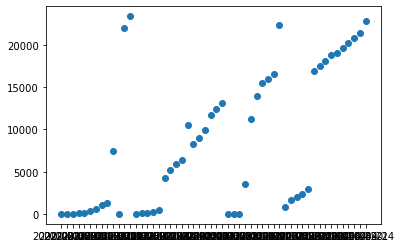

In [2]:
import matplotlib.pyplot as plt
x = df.data_relatorio
y = df.confirmados
plt.scatter(x, y)

In [3]:
import os
import sys
from osgeo import ogr
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/local/share/qgis/python')
from qgis.core import *
QgsApplication.setPrefixPath("/usr/local", True) 
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	/usr/local/./svg/
		C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/TIagoasfasf/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/TIagoasfasf/AppData/Roaming/python3\profiles\default/qgis-auth.db



In [4]:
covid_gpkg = "covid-pt-2020-04-20.gpkg"
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))


TypeError: 'NoneType' object is not iterable

In [5]:
concelho = QgsProject.instance().mapLayersByName('concelho')[0]
for c in concelho.getFeatures():
        print("Em {} há {} caso(s) confirmados".format(c["concelho"], c["confirmados_concelho_20/04/2020"]))

IndexError: list index out of range

In [ ]:
expr_sem_casos = QgsExpression( " \"confirmados_concelho_20/04/2020\" IS NULL " )
virgens = list(concelho.getFeatures( QgsFeatureRequest( expr_sem_casos ) ))
for c in virgens:
        print("Em {} não há pelos menos 3 casos confirmados".format(c["concelho"]))

In [ ]:
xt = concelho.extent()
# print(xt)
width  = 400
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([concelho])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()


In [ ]:
from IPython.display import Image

In [ ]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )